# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs and https://github.com/jayroxis/PINNs.git

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

### First order nonlinear ODE
$\begin{equation}
\frac{du}{dx} + xu^2 = 2\pi\cos(2\pi x) + x \sin^2(2\pi x),
\end{equation}$
with the initial condition $u(0) = 0$, $x \in [0,1]$. The excat solution is $u(x) = \sin{(2\pi x)}$.

In [15]:
import torch
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings

warnings.filterwarnings('ignore')

font = {'family': 'helvetica', 'size' :20}
plt.rc('font', **font)

np.random.seed(1234)

In [16]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Physics-informed Neural Networks

In [17]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [18]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, t, u, layers):
        
        # boundary conditions
        
        # data
        self.t = torch.tensor(t, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # settings
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-6, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, t):  
        u = self.dnn(t)
        return u
    
    def net_f(self, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = self.lambda_1     
        
        u = self.net_u(t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + lambda_1 * t* u ** 2 - 2*torch.pi*torch.cos(2*torch.pi*t) - t*torch.sin(2*torch.pi*t)**2
        return f
    
    def loss_func(self):
        u_pred = self.net_u(self.t)
        f_pred = self.net_f(self.t)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)

        return loss
    
    def train(self, nIter):
        self.dnn.train()
        It = []
        Loss = []
        lambda_1 = []
        for epoch in range(nIter):
            u_pred = self.net_u(self.t)
            f_pred = self.net_f(self.t)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e, Lambda_1: %.3f' % 
                    (
                        epoch, 
                        loss.item(), 
                        self.lambda_1.item()
                    )
                )

                It.append(epoch)
                Loss.append(loss.item())
                lambda_1.append(self.lambda_1.item())
            
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

        return(It, Loss, lambda_1)
        
    
    def predict(self, t):
        t = torch.tensor(t, requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(t)
        f = self.net_f(t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

## Training on Non-noisy Data

In [19]:
t_b = np.array([0.0])
u_b = np.array([0.0])

t = np.linspace(0,1,100)

N_u = 50
exat_u = np.sin(2*np.pi*t)

idx = np.random.choice(t.shape[0], N_u, replace=False)
t_f = t[idx]
u_f = exat_u[idx]

t_data = np.concatenate([t_b,t_f]).reshape(51,1)
u_data = np.concatenate([u_b,u_f]).reshape(51,1)



It: 0, Loss: 2.068e+01, Lambda_1: -0.001
It: 100, Loss: 2.038e+01, Lambda_1: -0.056
It: 200, Loss: 1.982e+01, Lambda_1: -0.100
It: 300, Loss: 1.879e+01, Lambda_1: -0.003
It: 400, Loss: 1.713e+01, Lambda_1: 0.243
It: 500, Loss: 1.461e+01, Lambda_1: 0.536
It: 600, Loss: 8.913e+00, Lambda_1: 0.929
It: 700, Loss: 4.354e+00, Lambda_1: 1.169
It: 800, Loss: 2.867e+00, Lambda_1: 1.292
It: 900, Loss: 2.087e+00, Lambda_1: 1.381
It: 1000, Loss: 1.587e+00, Lambda_1: 1.455
It: 1100, Loss: 1.238e+00, Lambda_1: 1.519
It: 1200, Loss: 9.801e-01, Lambda_1: 1.576
It: 1300, Loss: 7.684e-01, Lambda_1: 1.625
It: 1400, Loss: 5.844e-01, Lambda_1: 1.668
It: 1500, Loss: 4.214e-01, Lambda_1: 1.704
It: 1600, Loss: 2.747e-01, Lambda_1: 1.732
It: 1700, Loss: 1.449e-01, Lambda_1: 1.750
It: 1800, Loss: 6.525e-02, Lambda_1: 1.759
It: 1900, Loss: 4.228e-02, Lambda_1: 1.764
It: 2000, Loss: 3.381e-02, Lambda_1: 1.766
It: 2100, Loss: 2.868e-02, Lambda_1: 1.767
It: 2200, Loss: 2.534e-02, Lambda_1: 1.767
It: 2300, Loss: 2.3

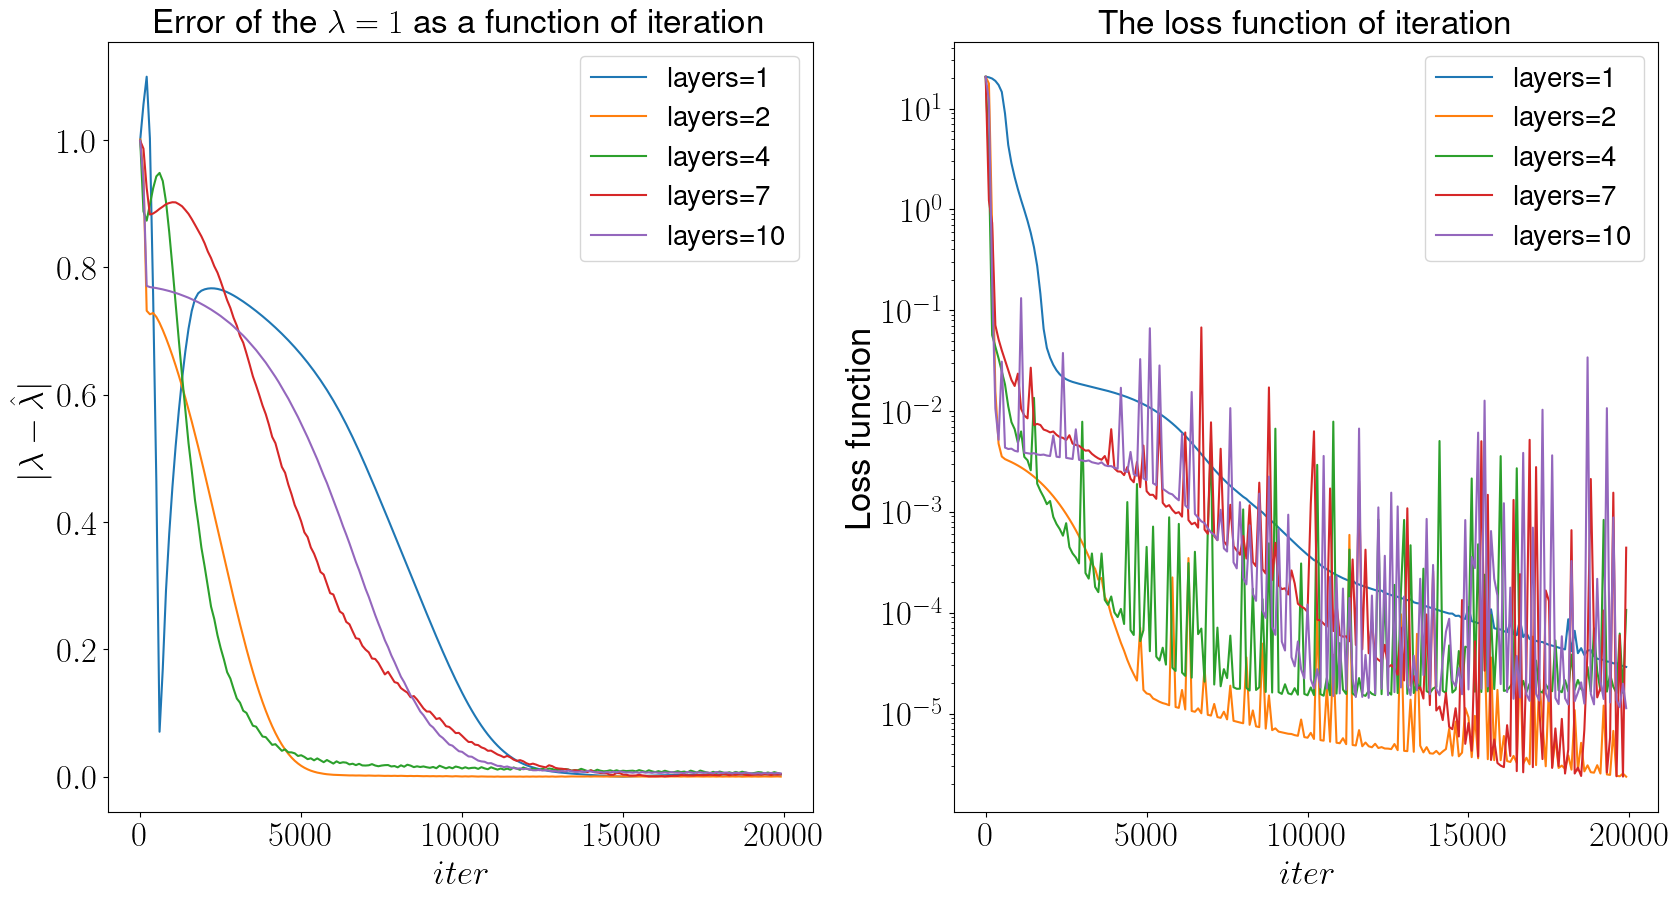

In [20]:
a = [1,2,4,7,10]
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1,2)

plot1 = plt.subplot(gs[0,0])
plot2 = plt.subplot(gs[0,1])

for i in range(len(a)):
    V1 = np.array([1])
    V2 = np.array([20]*a[i])
    V3 = np.array([1])
    layers = np.hstack([V1, V2, V3])
    model = PhysicsInformedNN(t_data, u_data, layers)
    It, Loss, Lambda_1 = model.train(20000)
    plot1.plot(It,np.abs(np.array(Lambda_1)-1),label = 'layers=%d'%a[i])  
    plot2.semilogy(It, Loss,label = 'layers=%d'%a[i]) 

plot1.set_xlabel('$iter$',fontsize=25)
plot1.set_ylabel('$|\lambda - \hat{\lambda}|$',fontsize=25)
plot1.set_title('Error of the $\lambda=1$ as a function of iteration')
plot1.legend(loc='upper right', fontsize=20)
plot1.tick_params(labelsize=25)

plot2.set_xlabel('$iter$',fontsize=25)
plot2.set_ylabel('Loss function',fontsize=25)
plot2.set_title('The loss function of iteration')
plot2.legend(loc='upper right', fontsize=20)
plot2.tick_params(labelsize=25)

plt.savefig("1st_nonlinear_lambda.pdf", format="pdf")

plt.show()


In [21]:
layers = [1, 20, 20, 1]

model = PhysicsInformedNN(t_data, u_data, layers)
model.train(20000)

It: 0, Loss: 2.063e+01, Lambda_1: 0.001
It: 100, Loss: 1.930e+01, Lambda_1: 0.066
It: 200, Loss: 4.189e+00, Lambda_1: 0.220
It: 300, Loss: 2.278e-02, Lambda_1: 0.282
It: 400, Loss: 5.954e-03, Lambda_1: 0.267
It: 500, Loss: 4.393e-03, Lambda_1: 0.291
It: 600, Loss: 3.931e-03, Lambda_1: 0.325
It: 700, Loss: 3.447e-03, Lambda_1: 0.361
It: 800, Loss: 2.968e-03, Lambda_1: 0.396
It: 900, Loss: 2.538e-03, Lambda_1: 0.432
It: 1000, Loss: 2.168e-03, Lambda_1: 0.468
It: 1100, Loss: 1.853e-03, Lambda_1: 0.504
It: 1200, Loss: 1.582e-03, Lambda_1: 0.539
It: 1300, Loss: 1.346e-03, Lambda_1: 0.574
It: 1400, Loss: 1.140e-03, Lambda_1: 0.609
It: 1500, Loss: 9.579e-04, Lambda_1: 0.643
It: 1600, Loss: 7.984e-04, Lambda_1: 0.676
It: 1700, Loss: 6.590e-04, Lambda_1: 0.708
It: 1800, Loss: 5.384e-04, Lambda_1: 0.738
It: 1900, Loss: 4.352e-04, Lambda_1: 0.767
It: 2000, Loss: 3.528e-04, Lambda_1: 0.795
It: 2100, Loss: 2.758e-04, Lambda_1: 0.820
It: 2200, Loss: 2.167e-04, Lambda_1: 0.844
It: 2300, Loss: 1.697e-

([0,
  100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200,
  1300,
  1400,
  1500,
  1600,
  1700,
  1800,
  1900,
  2000,
  2100,
  2200,
  2300,
  2400,
  2500,
  2600,
  2700,
  2800,
  2900,
  3000,
  3100,
  3200,
  3300,
  3400,
  3500,
  3600,
  3700,
  3800,
  3900,
  4000,
  4100,
  4200,
  4300,
  4400,
  4500,
  4600,
  4700,
  4800,
  4900,
  5000,
  5100,
  5200,
  5300,
  5400,
  5500,
  5600,
  5700,
  5800,
  5900,
  6000,
  6100,
  6200,
  6300,
  6400,
  6500,
  6600,
  6700,
  6800,
  6900,
  7000,
  7100,
  7200,
  7300,
  7400,
  7500,
  7600,
  7700,
  7800,
  7900,
  8000,
  8100,
  8200,
  8300,
  8400,
  8500,
  8600,
  8700,
  8800,
  8900,
  9000,
  9100,
  9200,
  9300,
  9400,
  9500,
  9600,
  9700,
  9800,
  9900,
  10000,
  10100,
  10200,
  10300,
  10400,
  10500,
  10600,
  10700,
  10800,
  10900,
  11000,
  11100,
  11200,
  11300,
  11400,
  11500,
  11600,
  11700,
  11800,
  11900,
  12000,
  12100,
  12200,
  123

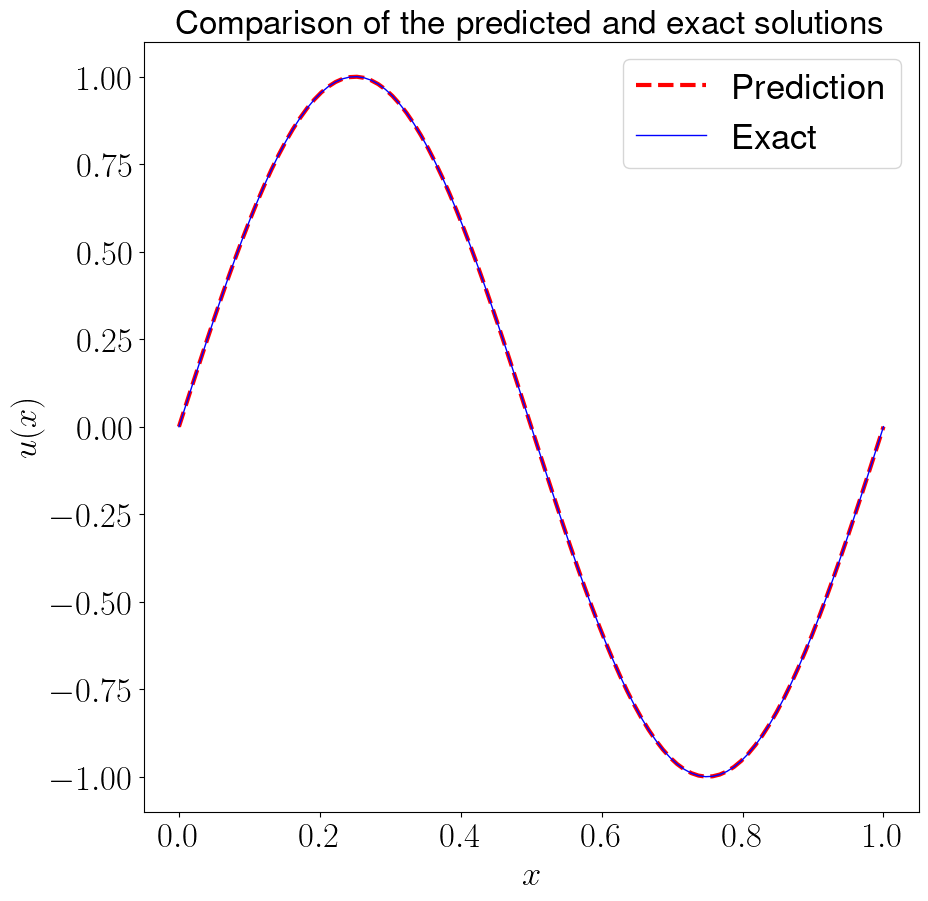

In [22]:
t = t.reshape(100,1)
u_pred, f_pred = model.predict(t) 

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(t,u_pred,'r--',linewidth = 3, label='Prediction')
ax.plot(t,exat_u,'b-', linewidth = 1, label = 'Exact')
ax.set_xlabel('$x$', fontsize=25)
ax.set_ylabel('$u(x)$', fontsize=25)
ax.set_title('Comparison of the predicted and exact solutions')
ax.legend(fontsize=25)
ax.tick_params(labelsize=25)

plt.savefig("1st_nonlinear_prediction.pdf", format="pdf")

plt.show()

In [23]:
lambda_1_value = model.lambda_1.detach().cpu().numpy()
error_lambda_1 = np.abs(lambda_1_value - 1.0)*100
print('Error l1: %.5f%%' % (error_lambda_1))                            

Error l1: 0.05350%


## Training on Noisy Data

In [24]:
noise = 0.01    

# create training set
u_train_noise = u_data + noise*np.std(u_data)*np.random.randn(u_data.shape[0], u_data.shape[1])

model = PhysicsInformedNN(t_data, u_train_noise, layers)
model.train(20000)

It: 0, Loss: 2.056e+01, Lambda_1: 0.001
It: 100, Loss: 1.782e+01, Lambda_1: 0.115
It: 200, Loss: 1.053e+00, Lambda_1: 0.330
It: 300, Loss: 6.025e-03, Lambda_1: 0.350
It: 400, Loss: 4.043e-03, Lambda_1: 0.350
It: 500, Loss: 3.348e-03, Lambda_1: 0.353
It: 600, Loss: 3.014e-03, Lambda_1: 0.358
It: 700, Loss: 2.832e-03, Lambda_1: 0.363
It: 800, Loss: 2.718e-03, Lambda_1: 0.370
It: 900, Loss: 2.630e-03, Lambda_1: 0.378
It: 1000, Loss: 2.552e-03, Lambda_1: 0.387
It: 1100, Loss: 2.476e-03, Lambda_1: 0.396
It: 1200, Loss: 2.398e-03, Lambda_1: 0.406
It: 1300, Loss: 2.317e-03, Lambda_1: 0.417
It: 1400, Loss: 2.234e-03, Lambda_1: 0.428
It: 1500, Loss: 2.148e-03, Lambda_1: 0.440
It: 1600, Loss: 2.060e-03, Lambda_1: 0.453
It: 1700, Loss: 1.969e-03, Lambda_1: 0.466
It: 1800, Loss: 1.878e-03, Lambda_1: 0.480
It: 1900, Loss: 1.785e-03, Lambda_1: 0.494
It: 2000, Loss: 1.691e-03, Lambda_1: 0.508
It: 2100, Loss: 1.597e-03, Lambda_1: 0.524
It: 2200, Loss: 1.502e-03, Lambda_1: 0.539
It: 2300, Loss: 1.408e-

([0,
  100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200,
  1300,
  1400,
  1500,
  1600,
  1700,
  1800,
  1900,
  2000,
  2100,
  2200,
  2300,
  2400,
  2500,
  2600,
  2700,
  2800,
  2900,
  3000,
  3100,
  3200,
  3300,
  3400,
  3500,
  3600,
  3700,
  3800,
  3900,
  4000,
  4100,
  4200,
  4300,
  4400,
  4500,
  4600,
  4700,
  4800,
  4900,
  5000,
  5100,
  5200,
  5300,
  5400,
  5500,
  5600,
  5700,
  5800,
  5900,
  6000,
  6100,
  6200,
  6300,
  6400,
  6500,
  6600,
  6700,
  6800,
  6900,
  7000,
  7100,
  7200,
  7300,
  7400,
  7500,
  7600,
  7700,
  7800,
  7900,
  8000,
  8100,
  8200,
  8300,
  8400,
  8500,
  8600,
  8700,
  8800,
  8900,
  9000,
  9100,
  9200,
  9300,
  9400,
  9500,
  9600,
  9700,
  9800,
  9900,
  10000,
  10100,
  10200,
  10300,
  10400,
  10500,
  10600,
  10700,
  10800,
  10900,
  11000,
  11100,
  11200,
  11300,
  11400,
  11500,
  11600,
  11700,
  11800,
  11900,
  12000,
  12100,
  12200,
  123

In [25]:
lambda_1_value_noise = model.lambda_1.detach().cpu().numpy()
error_lambda_1_noise = np.abs(lambda_1_value_noise - 1.0)*100
print('Error l1: %.5f%%' % (error_lambda_1_noise))

Error l1: 0.44733%


### Identified ODE

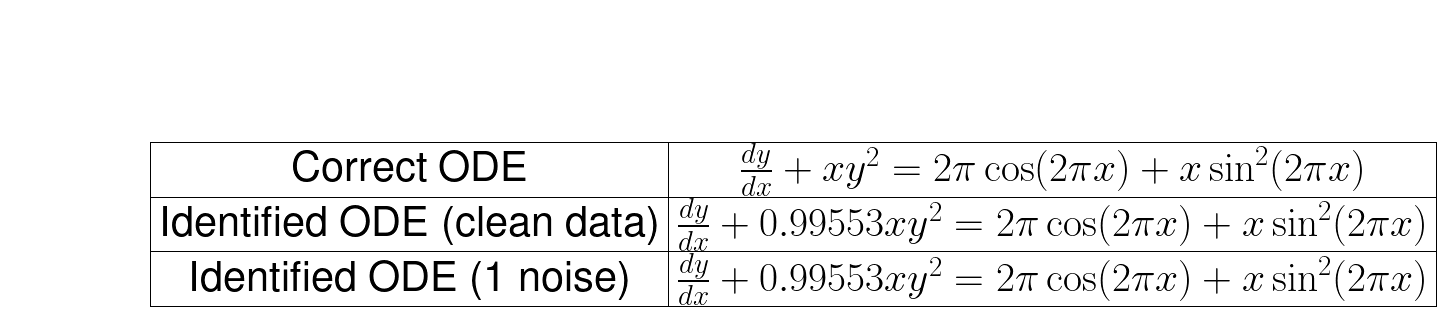

In [26]:
####### Row 3: Identified PDE ##################    
lambda_1_value = model.lambda_1[0]

fig = plt.figure(figsize=(14, 10))

gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=0.25, bottom=0, left=0.0, right=1.0, wspace=0.0)

ax = plt.subplot(gs2[:, :])
ax.axis('off')

s1 = r'$\begin{tabular}{ |c|c| }  \hline Correct ODE & $\frac{dy}{dx} + xy^2 = 2\pi\cos(2\pi x) + x \sin^2(2\pi x)$ \\'
s2 = r'\hline Identified ODE (clean data) & $\frac{dy}{dx} + %.5f xy^2 = 2\pi\cos(2\pi x) + x \sin^2(2\pi x)$ \\' % (lambda_1_value)
s3 = r'\hline Identified ODE (1 noise) & $\frac{dy}{dx} + %.5f xy^2 = 2\pi\cos(2\pi x) + x \sin^2(2\pi x)$ \\' % (lambda_1_value_noise)
s4 = r'\hline \end{tabular}$'
s = s1+s2+s3+s4
ax.text(0.1, 0.1, s, size=30)

plt.show()